In [2]:
#Importing necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from keras.callbacks import EarlyStopping
import keras
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import AUC
%matplotlib inline

In [3]:
# define constants
img_width, img_height = 100, 100
target_size = (100,100)
batch_size = 64
epochs = 1
learning_rate = 0.1
col = 5

In [4]:
# Set the paths to your training, validation, and testing folders
train_folder = "Original Images/a. Training Set"
valid_folder = "Original Images/b. Validation Set"
test_folder = "Original Images/c. Testing Set"

# Set the paths to your training, validation, and testing CSV files for labels
train_labels_file = "Groundtruths/training28.csv"
valid_labels_file = "Groundtruths/validation28.csv"
test_labels_file = "Groundtruths/testing28.csv"

In [5]:
# Load the CSV file with image filenames and labels
train_labels_df = pd.read_csv(train_labels_file)
valid_labels_df = pd.read_csv(valid_labels_file)
test_labels_df = pd.read_csv(test_labels_file)

# Remove rows from dataframes where filenames are missing
missing_rows = [1506,1505,1744,1752,1753,1756,1762,1770,1781,1788,1792,1842,1846,1873,1878] 
train_labels_df.drop(missing_rows, inplace=True)
missing_rows = [549,550,552,560,590,596]
valid_labels_df.drop(missing_rows, inplace=True)
missing_rows = [553,590,592,564,614,617,622,624,628]
test_labels_df.drop(missing_rows, inplace=True)

# Add the .png extension to the filenames
train_labels_df['ID'] = train_labels_df['ID'].apply(lambda x: str(x) + '.png')
valid_labels_df['ID'] = valid_labels_df['ID'].apply(lambda x: str(x) + '.png')
test_labels_df['ID'] = test_labels_df['ID'].apply(lambda x: str(x) + '.png')

# Calculate the number of positive cases in each label except the ID column
label_counts = train_labels_df.iloc[:, 1:].sum(axis=0)

# Sort the labels in descending order by number of positive cases
sorted_labels = label_counts.sort_values(ascending=False)

# Reorder the columns in train_df, valid_df, and test_df using the sorted label order
# train_labels_df = train_labels_df[['ID'] + list(sorted_labels.index)]
# valid_labels_df = valid_labels_df[['ID'] + list(sorted_labels.index)]
# test_labels_df = test_labels_df[['ID'] + list(sorted_labels.index)]

#Dropping disease risk label
train_labels_df = train_labels_df.drop('Disease_Risk', axis=1).drop('DR', axis=1)
valid_labels_df = valid_labels_df.drop('Disease_Risk', axis=1).drop('DR', axis=1)
test_labels_df = test_labels_df.drop('Disease_Risk', axis=1).drop('DR', axis=1)

#Dropping 20 label
r = col-27
train_labels_df = train_labels_df.iloc[:, :r]
valid_labels_df = valid_labels_df.iloc[:, :r]
test_labels_df = test_labels_df.iloc[:, :r]

# Print the updated dataframe to verify the sorting
print(train_labels_df.head())
train_labels_df.columns

      ID  ARMD  MH  DN  MYA  BRVO
0  1.png     0   0   0    0     0
1  2.png     0   0   0    0     0
2  3.png     0   0   0    0     0
3  4.png     0   1   0    0     0
4  5.png     0   0   0    0     0


Index(['ID', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO'], dtype='object')

In [6]:
# create class weight dictionary
class_weights = {}
i=0
for label in train_labels_df.columns[1:]:
    freq = np.sum(train_labels_df[label] == 1)
    class_weights[i] = len(train_labels_df) / freq
    i+=1

In [7]:
print(class_weights)

{0: 19.05, 1: 6.145161290322581, 2: 13.804347826086957, 3: 18.861386138613863, 4: 26.095890410958905}


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.05,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory=train_folder,
    x_col="ID",
    y_col=train_labels_df.columns[1:],
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(img_height, img_width),
    class_weight=class_weights)

Found 1905 validated image filenames.


In [9]:
print("Total number of images in train_generator:", train_generator.n)

Total number of images in train_generator: 1905


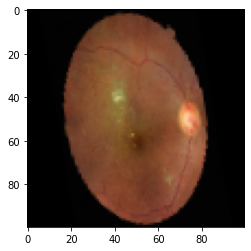

[0 0 0 0 0]


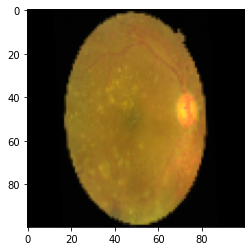

In [10]:
# get a batch of data and labels from the train generator
x_batch, y_batch = next(train_generator)

# plot the first image in the batch
plt.imshow(x_batch[0])
plt.show()
print(y_batch[0])
plt.imshow(x_batch[1])
plt.show()


In [11]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow generators for the validation set
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_labels_df,
    directory=valid_folder,
    x_col='ID',
    y_col=valid_labels_df.columns[1:],
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False)


# Create flow generators for the testing set
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_folder,
    x_col='ID',
    y_col=valid_labels_df.columns[1:],
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False)

Found 634 validated image filenames.
Found 631 validated image filenames.


In [12]:
# Original dataset label frequency
orig_label_freq = train_labels_df.iloc[:, 1:].sum().tolist()
print(orig_label_freq)

# Augmented dataset label frequency
aug_label_freq = train_generator.labels.sum(axis=0)
print(aug_label_freq)

[100, 310, 138, 101, 73]
[100 310 138 101  73]


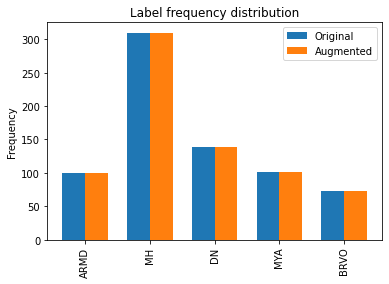

In [13]:
# Create a bar plot
ind = np.arange(len(orig_label_freq))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, orig_label_freq, width, label='Original')
rects2 = ax.bar(ind + width/2, aug_label_freq, width, label='Augmented')

# Add labels and title
ax.set_xticks(ind)
ax.set_xticklabels(train_labels_df.columns[1:], rotation = 90)
ax.set_ylabel('Frequency')
ax.set_title('Label frequency distribution')
ax.legend()

# Show the plot
plt.show()

In [14]:
# Create ResNet50 model with pre-trained weights on ImageNet
base_model = ResNet50(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
    
# add custom head
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(col, activation='sigmoid')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=x)

# Define loss function, optimizer, and learning rate
loss_function = BinaryCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

# def macro_auc(y_true, y_pred):
#     auc_scores = []
#     for i in range(y_true.shape[1]):
#         try:
#             auc = roc_auc_score(y_true[:, i], y_pred[:, i], average='macro')
#         except ValueError:
#             auc = 0.5
#         auc_scores.append(auc)
#     return tf.reduce_mean(auc_scores)

thresh = 0.9

def binary_accuracy_with_threshold(y_true, y_pred, threshold=thresh):
    y_pred = tf.keras.backend.round(y_pred + 0.5 - threshold)
    correct_predictions = tf.keras.backend.cast(tf.keras.backend.equal(y_true, y_pred), tf.float32)
    return tf.keras.backend.mean(correct_predictions)

# Define AUC as a metric
def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

# Define metrics
# metrics = ['accuracy'
#            #, AUC(name='auc'), macro_auc
#            ]
# Define metrics
metrics = [
    tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='binary_accuracy_with_threshold'),
    AUC(name='auc')
]

# Compile the model
model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [15]:
# Train the model
history = model.fit(train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    #class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1,
    workers=4,
    use_multiprocessing=True,
    shuffle=True)

Exception in thread Thread-3:
Traceback (most recent call last):
  File "c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\threading.py", line 954, in _bootstrap_inner
    self.run()
  File "c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\data_utils.py", line 781, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\data_utils.py", line 756, in pool_fn
    pool = get_pool_class(True)(
  File "c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\mul

In [ ]:
threshold = 0.2
test_results = model.evaluate(test_generator, batch_size=batch_size, verbose=1)
test_loss = test_results[0]
test_acc = test_results[1]
test_auc = test_results[2]


# make predictions on test set with threshold
y_pred = (model.predict(test_generator) >= threshold).astype(int)

10/10 [==============================] - 71s 7s/step


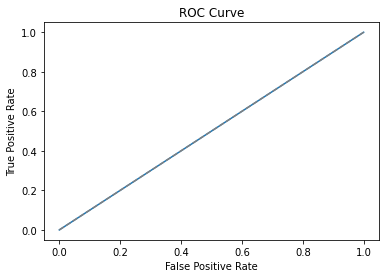

In [ ]:
from sklearn.preprocessing import label_binarize

# Get true labels for test set
y_true = test_generator.labels

# Convert labels to binary format
y_true_binary = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

# Generate ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_true_binary.ravel(), y_pred.ravel())

# Plot ROC AUC curve
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', color='gray', label='No Predictive Value')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print(test_labels_df.columns)

Index(['ID', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO'], dtype='object')


Test loss: 0.4190257489681244
Test accuracy: 0.9255150556564331
Test AUC: 0.6526464819908142
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82       439
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        23

    accuracy                           0.70       631
   macro avg       0.14      0.20      0.16       631
weighted avg       0.48      0.70      0.57       631



c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Deependra Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

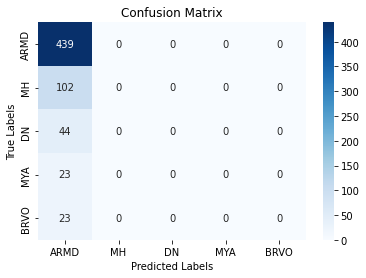

In [ ]:
# convert multilabel-indicator format labels to 1D array of class labels
y_true1 = np.argmax(test_generator.labels, axis=1)
y_pred1 = np.argmax(y_pred, axis=1)

# compute confusion matrix
cm = confusion_matrix(y_true1, y_pred1)

# create heatmap from confusion matrix
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=test_labels_df.columns[1:], yticklabels=test_labels_df.columns[1:])
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# compute classification report
cr = classification_report(y_true1, y_pred1)

# print evaluation results
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
print('Test AUC:', test_auc)
print("Classification Report:\n", cr)

In [ ]:
# # Test the model on the test generator
# test_loss, test_acc, test_auc = model.evaluate(test_generator)
# print('Test accuracy:', test_acc)
# print('Test AUC:', test_auc)

In [ ]:
# # Train the model
# history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator)

In [ ]:
# # Evaluate the model on the test set
# scores = model.evaluate(test_generator, verbose=0)
# print("Test Loss:", scores[0])
# print("Test Accuracy:", scores[1])

# # Make predictions on the test set
# y_pred = model.predict(test_generator)

# # Calculate the ROC AUC score for each class
# roc_auc_scores = roc_auc_score(test_generator.labels, y_pred, average=None)

# # Plot the ROC AUC curve for each class
# fpr = dict()
# tpr = dict()
# for i in range(len(labels)):
#     fpr[i], tpr[i], _ = roc_curve(test_generator.labels[:, i], y_pred[:, i])
#     plt.plot(fpr[i], tpr[i], label=f"ROC curve of {labels[i]} (AUC = {roc_auc_scores[i]:.2f})")
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC AUC Curve')
# plt.legend(loc="lower right")
# plt.show()